<a href="https://colab.research.google.com/github/Nosrednum/ForToday/blob/master/nn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
import urllib.request 
import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from tensorflow.keras import activations

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/sebastiandiazmujica/gis-ml/master/"
TRAINING_PATH = os.path.join("datasets", "training")
TRAINING_URL = DOWNLOAD_ROOT + "datasets/training/arroz.csv"

'''
Crea el directorio de los datos, y descarga los datos (.csv) en la carpeta training
'''
os.makedirs(TRAINING_PATH, exist_ok = True)
archive_path = os.path.join(TRAINING_PATH, "arroz.csv")
urllib.request.urlretrieve(TRAINING_URL, archive_path)

('datasets/training/arroz.csv', <http.client.HTTPMessage at 0x7f171bf46320>)

In [ ]:
INPUT_SIZE = 7
NUM_CLASES = 11
data = pd.read_csv("datasets/training/arroz.csv", sep=';', skiprows=0)

def create_training_data():
  X = data.iloc[:, [2,3,4,5,6,7,8]].values
  y = data.iloc[:,-1].values

  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
  
  for train_index, test_val_index in sss.split(X, y):
    X_train, X_test_val = preprocessing.scale(X[train_index]), X[test_val_index]
    y_train, y_test_val = tf.one_hot(y[train_index]-1, NUM_CLASES), y[test_val_index]

  sss2 =StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

  for  validation_index, test_index in sss2.split(X_test_val, y_test_val):
    X_test, X_val = preprocessing.scale(X_test_val[test_index]), preprocessing.scale(X_test_val[validation_index])
    y_test, y_val = tf.one_hot(y_test_val[test_index]-1, NUM_CLASES), tf.one_hot(y_test_val[validation_index]-1, NUM_CLASES)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = create_training_data()

Se prueban como hiperparametros
- inicializador: glorot normal
- activacion: relu
- forma de la red: [(11, 13, 11), (11,13,13,11), (11,13,15,13,11)]
- optimizador: [rms, adam]
  - learning rate: [1e-3:1e-1]
  - beta: [1-1e-1:1-1e-3]


In [ ]:
# se importan las librerias estandar
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [ ]:
# se importa de tensorflow lo necesario para crear una red secuancial
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model

In [ ]:
!pip install scikit-optimize #Instalación del optimizador de modelos

     |████████████████████████████████| 102kB 2.2MB/s 


In [ ]:
import skopt #optimizador global que busca minimizar el valor pasado por parametro
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [ ]:
#creamos una dimension para cada hiperparametro
#la dimensión es un rango de valores para los cuales se tomarán muestras y se variará sobre ellos
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=5, high=64, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu'], name='activation')#, 'sigmoid'], name='activation')
#cramos una lista de dimensiones (el orden importa)
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

In [ ]:
def log_dir_name(learning_rate, num_dense_layers, num_dense_nodes, activation):
  '''
    Inserta en la carpeta el log correspondiente a una prueba con determinados
    hiperparametros
  '''
    # The dir-name for the TensorBoard log-dir.
  s = "./hplog/lr_{0:.0e}_({1}:{2})_{3}/"
  # Insert all the hyper-parameters in the dir-name.
  log_dir = s.format(learning_rate,
                     num_dense_layers,
                     num_dense_nodes,
                     activation)
  return log_dir

In [ ]:
INPUT_SIZE=7
OUTPUT_SIZE=11
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Creación del modelo a optimizar
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """    
    # Crea un modelo secuencial vacio para pooder manipular su estructura
    model = Sequential()

    # Añade la capa de entrada a la red
    model.add(InputLayer(input_shape=(INPUT_SIZE,)))

    # Añade capas densamente conectadas entre 1 y num_dense_layers+1.
    # Buscamos optimizar este valor (es un hiperparametro)
    #la capa se añade con la activación y tamaño pasados por parametro
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))
    # Ultima capa densamente conectada con activación softmax
    # usada para clasificación.
    model.add(Dense(OUTPUT_SIZE, activation='softmax'))
    
    # Utilizando los optimizadores hallaremos, cuando menos la mejor learning rate
    optimizer = RMSprop(learning_rate=learning_rate )
    #optimizer = Adam(lr=learning_rate)
    
    # Compilamos el modelo en keras para luego entrenarlo
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
path_best_model = 'nn_best_model.h5' # archivo con el mejor modelo hallado
best_accuracy = 0.0 #mejor accuracy encontrado para el mejor modelo
epochs = 20

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation):
    # Antes de empezar a ajustar se imprimen los argumentos de los hiperparametros
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Crea el modelo con los hiperparametros (usa el método definido arriba)
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # da el nombre para el log de tensorboard
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Crea el callback para el log de tensorboard
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Entrena el modelo.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        batch_size=128,
                        validation_data=(X_val, y_val),
    )
    #                    callbacks=[callback_log])

    # Obtiene la precición despues del último paso (en validación)
    accuracy = history.history['val_accuracy'][-1]
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Actualizamos el mejor valor y guardamos el modelo (si es mejor)
    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    # borra el modelo por memoria y caché
    del model
    # Limpia keras para hacer un flush de los modelos
    K.clear_session()
    
    # Optimiza al minimo
    return -accuracy

In [ ]:
#Prueba de entrenamiento
default_parameters = [4e-3, 2, 16, 'relu']
#fitnes es la función que entrena el modelo, limpia la sesión, y lo guarda si mejora el accuracy previo
fitness(x=default_parameters)

learning rate: 4.0e-03
num_dense_layers: 2
num_dense_nodes: 16
activation: relu

Epoch 1/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.8130 - accuracy: 0.7175 - val_loss: 0.6855 - val_accuracy: 0.7678
Epoch 2/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6569 - accuracy: 0.7713 - val_loss: 0.6322 - val_accuracy: 0.7775
Epoch 3/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6238 - accuracy: 0.7809 - val_loss: 0.6176 - val_accuracy: 0.7829
Epoch 4/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6035 - accuracy: 0.7883 - val_loss: 0.5968 - val_accuracy: 0.7909
Epoch 5/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.5929 - accuracy: 0.7923 - val_loss: 0.6606 - val_accuracy: 0.7661
Epoch 6/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.5856 - accuracy: 0.7948 - val_loss: 0.5916 - val_accuracy: 0.7913
Epoch 7/20
3618/3618 [==============================] -

-0.8132829070091248

In [ ]:
#imprime el tiempo de ejecución
%%time 

# Ejecuta una busqueda entre las dimensiones alterando la función fitness
# con el objetivo de minimizar el valor a optimizar, en este caso el accuracy negativo,
# y guarda el registro de sus iteraciones para poder comparar
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 4.0e-03
num_dense_layers: 2
num_dense_nodes: 16
activation: relu

Epoch 1/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.7813 - accuracy: 0.7252 - val_loss: 0.6861 - val_accuracy: 0.7556
Epoch 2/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6582 - accuracy: 0.7689 - val_loss: 0.6393 - val_accuracy: 0.7757
Epoch 3/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6276 - accuracy: 0.7785 - val_loss: 0.6565 - val_accuracy: 0.7697
Epoch 4/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.6059 - accuracy: 0.7866 - val_loss: 0.6224 - val_accuracy: 0.7796
Epoch 5/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.5900 - accuracy: 0.7928 - val_loss: 0.5761 - val_accuracy: 0.7980
Epoch 6/20
3618/3618 [==============================] - 4s 1ms/step - loss: 0.5766 - accuracy: 0.7974 - val_loss: 0.5899 - val_accuracy: 0.7895
Epoch 7/20
3618/3618 [==============================] -

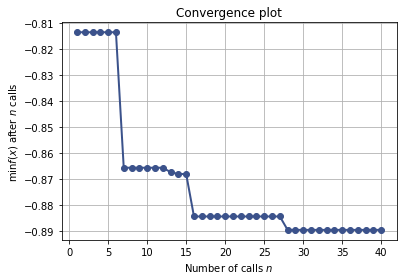

In [ ]:
# plotea los valores optimizados aluego de n iteraciones
plot_convergence(search_result)

In [ ]:
search_result.x

[0.0008563342297808483, 5, 64, 'relu']

In [ ]:
search_result.fun

-0.8896490931510925

ValueError: ignored

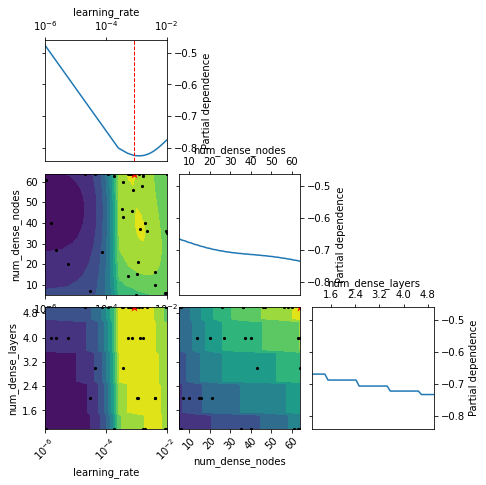

In [ ]:
fig, ax = plot_objective(result=search_result, plot_dims=['learning_rate', 'num_dense_nodes', 'num_dense_layers'])

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8896490931510925, [0.0008563342297808483, 5, 64, 'relu']),
 (-0.8844658732414246, [0.000643983419803121, 5, 64, 'relu']),
 (-0.8834119439125061, [0.0007972965968572502, 5, 64, 'relu']),
 (-0.8829454779624939, [0.0006959414947765679, 5, 64, 'relu']),
 (-0.8756025433540344, [0.00053805926948173, 5, 64, 'relu']),
 (-0.8739439249038696, [0.0008083623215973162, 5, 56, 'relu']),
 (-0.8715078234672546, [0.0011959024320921496, 5, 64, 'relu']),
 (-0.8681214451789856, [0.0007365054613813541, 5, 46, 'relu']),
 (-0.8673784732818604, [0.0003567115283423288, 5, 60, 'relu']),
 (-0.8657025694847107, [0.0016034681316048727, 5, 58, 'relu']),
 (-0.8635601997375488, [0.0007487751388150632, 4, 64, 'relu']),
 (-0.8618842959403992, [0.0013758574458821477, 4, 37, 'relu']),
 (-0.8491162657737732, [0.0022963777514262485, 5, 36, 'relu']),
 (-0.8483042120933533, [0.000329251414402943, 5, 47, 'relu']),
 (-0.8322708010673523, [0.0016149111332506218, 4, 63, 'relu']),
 (-0.8311477303504944, [0.000116642395321799

In [ ]:
model = load_model(path_best_model)
result = model.evaluate(x=X_test,
                        y=y_test)
print("Accuracy: {0:.12%}".format(result[1]))
print("Loss: {0:.2%}".format(result[0]))

1809/1809 [==============================] - 2s 888us/step - loss: 0.3265 - accuracy: 0.8897
Accuracy: 88.972008228302%
Loss: 32.65%
